# Analysis & Visualization Notebook for Grayscale vs. Color Experiments

# Imports

In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from IPython.display import display, Markdown

/Users/david/local/Waseda/Seminar/Search/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Aggregating Results

In [2]:
results_dir = "results"

records = []
for fname in os.listdir(results_dir):
    if fname.endswith('.json'):
        with open(os.path.join(results_dir, fname), 'r') as f:
            records.append(json.load(f))
df = pd.DataFrame(records)
df = df.sort_values(['experiment', 'repeat']).reset_index(drop=True)

# Compute summary
summary = df.groupby('experiment').agg({
    'val_acc': ['mean', 'std'],
    'train_time_sec': 'mean',
    'inf_time_cpu_sec': 'mean',
    'inf_mem_cpu_MB': 'mean',
    'model_params': 'mean'
}).round(4)
summary.columns = ['_'.join(col) for col in summary.columns]
summary.reset_index(inplace=True)

# Pretty labels for experiments
label_map = {
    'color_baseline': "Color (baseline)",
    'grayscale_baseline': "Grayscale",
    'grayscale_aug': "Grayscale + Aug.",
    'grayscale_offline_aug_100k': "Gray + Offline Aug.",
    'color_on_gray_test': "Color model on Gray test",
    'grayscale_on_color_test': "Gray model on Color test",
    'grayscale_aug_on_color_test': "Gray + Aug. model on Color test"
}
summary['experiment_label'] = summary['experiment'].map(label_map)
summary = summary.sort_values('experiment_label')

# Plots and Analysis

In [3]:
display(Markdown("## Experiment Summary Table"))
display(summary[['experiment_label', 'val_acc_mean', 'val_acc_std', 'train_time_sec_mean', 'inf_time_cpu_sec_mean', 'model_params_mean']])

## Experiment Summary Table

,experiment_label,val_acc_mean,val_acc_std,train_time_sec_mean,inf_time_cpu_sec_mean,model_params_mean
0,Color (baseline),0.7354,0.0097,236.7300,0.0419,591274.0
1,Color model on Gray test,0.6661,0.0180,230.4301,0.0493,591274.0
3,Gray + Aug. model on Color test,0.5878,0.2648,231.5882,0.0493,590698.0
5,Gray + Offline Aug.,0.6627,0.0155,525.2835,0.0412,590698.0
6,Gray model on Color test,0.7175,0.0038,228.3610,0.0424,590698.0
4,Grayscale,0.7175,0.0038,238.0059,0.0467,590698.0
2,Grayscale + Aug.,0.5878,0.2648,250.5129,0.0498,590698.0


## Learning Curves

In [4]:
def plot_learning_curves(exp_name, repeats=3, hist_dir="histories"):
    plt.figure(figsize=(12, 5))
    # Plot loss
    plt.subplot(1,2,1)
    for rep in range(repeats):
        hist_file = os.path.join(hist_dir, f"{exp_name}_rep{rep}_history.json")
        if os.path.exists(hist_file):
            with open(hist_file, 'r') as f:
                hist = json.load(f)
            plt.plot(hist['loss'], label=f"Train rep {rep+1}", alpha=0.7)
            plt.plot(hist['val_loss'], label=f"Val rep {rep+1}", alpha=0.7, linestyle='--')
    plt.title(f"Loss - {exp_name}")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    # Plot accuracy
    plt.subplot(1,2,2)
    for rep in range(repeats):
        hist_file = os.path.join(hist_dir, f"{exp_name}_rep{rep}_history.json")
        if os.path.exists(hist_file):
            with open(hist_file, 'r') as f:
                hist = json.load(f)
            plt.plot(hist['accuracy'], label=f"Train rep {rep+1}", alpha=0.7)
            plt.plot(hist['val_accuracy'], label=f"Val rep {rep+1}", alpha=0.7, linestyle='--')
    plt.title(f"Accuracy - {exp_name}")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

## Learning Curves

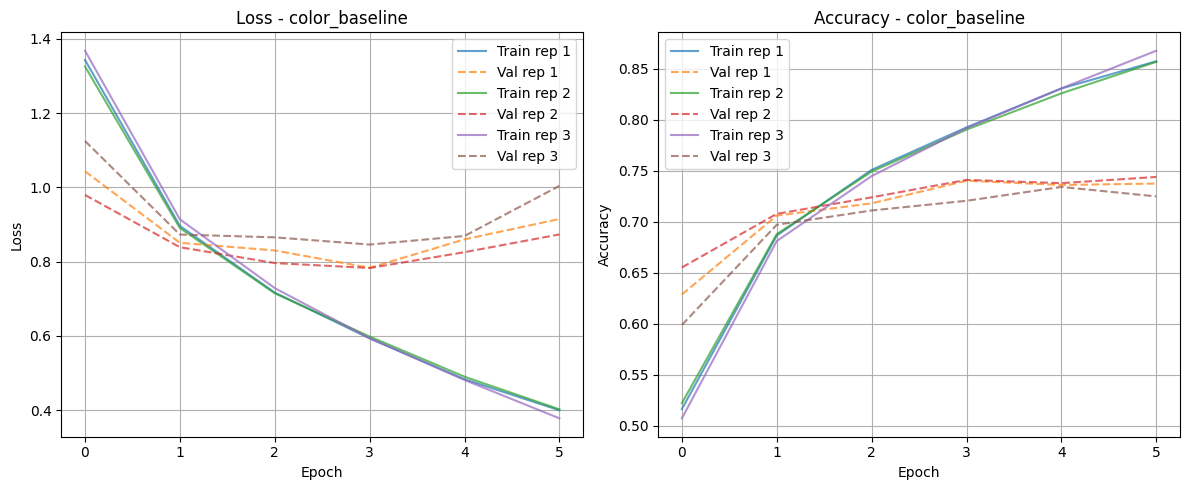

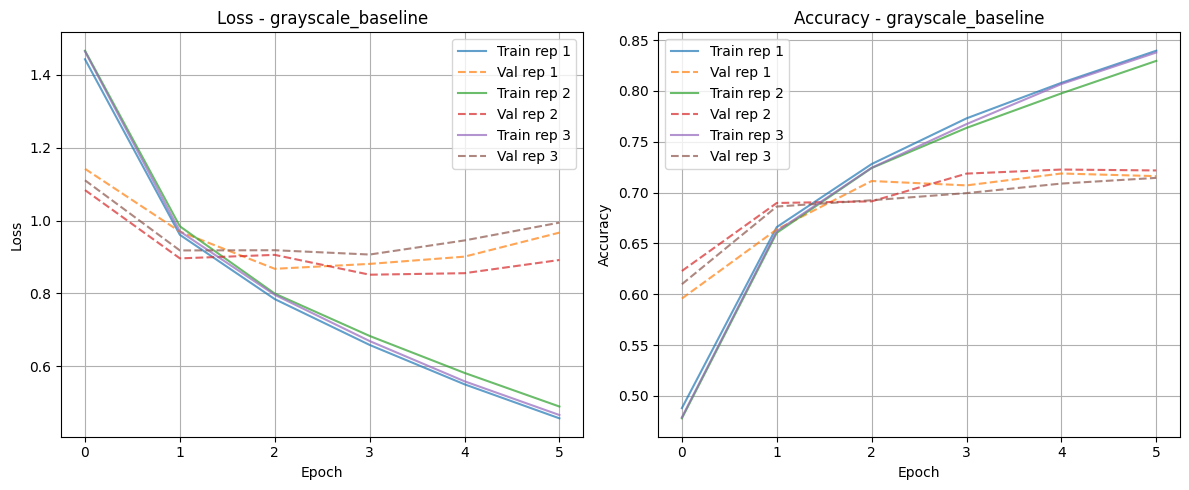

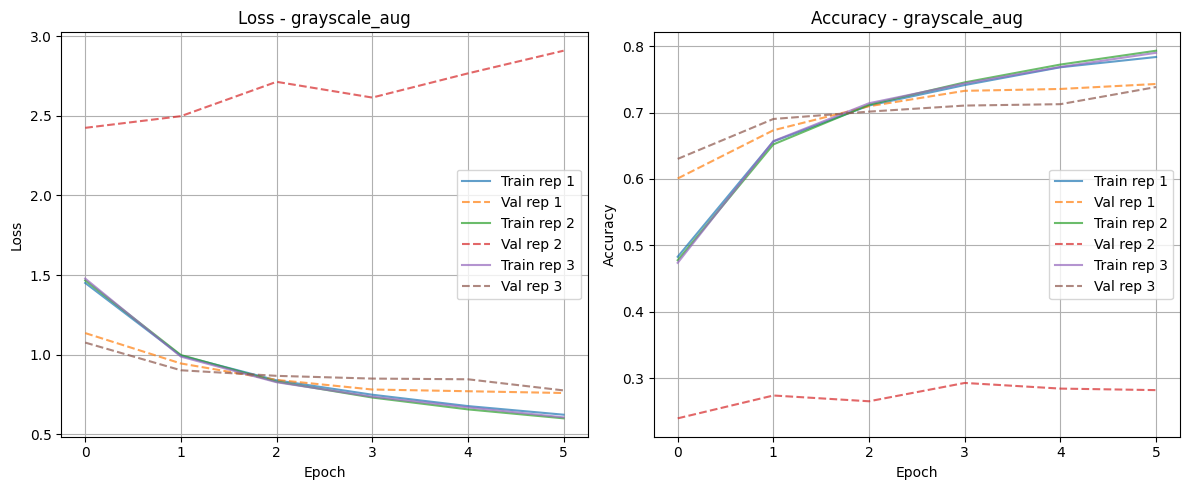

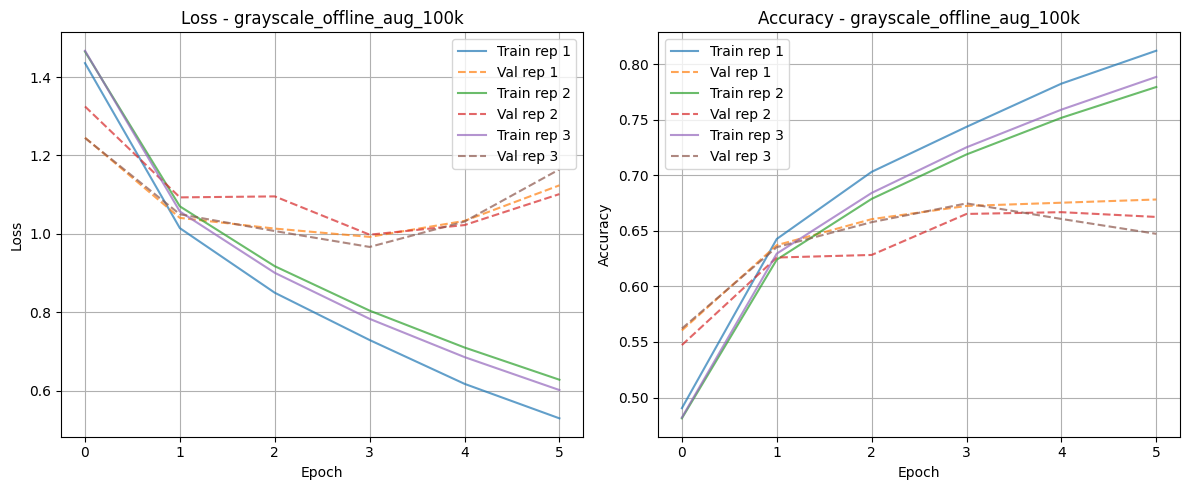

In [5]:
display(Markdown("## Learning Curves"))
for exp in ['color_baseline', 'grayscale_baseline', 'grayscale_aug', 'grayscale_offline_aug_100k']:
    plot_learning_curves(exp)

## Confusion Matrices for Key Experiments

## Confusion Matrices (Repeat 0 Models)

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


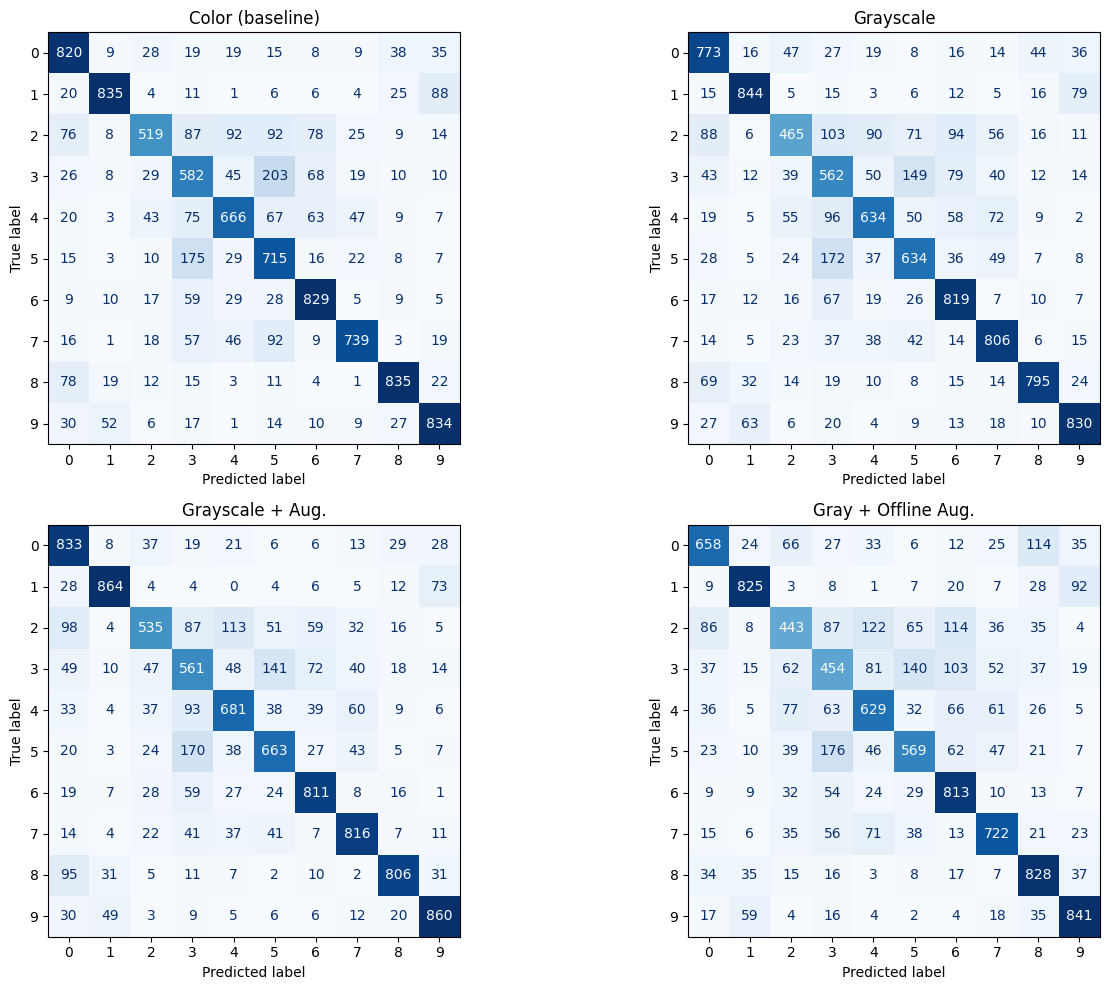

In [6]:
# Load CIFAR-10 test data
(_, _), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_test = x_test.astype("float32") / 255.0
y_test = y_test.flatten()

def load_and_predict(model_path, x, grayscale=False):
    """Load model and make predictions. Grayscale if needed."""
    model = tf.keras.models.load_model(model_path)
    if grayscale:
        x_input = np.dot(x[...,:3], [0.299, 0.587, 0.114])[..., np.newaxis]
    else:
        x_input = x
    y_pred = model.predict(x_input, batch_size=128)
    return np.argmax(y_pred, axis=1)

# Choose best models for comparison (repeat 0)
model_paths = {
    "Color (baseline)": "saved_models/color_baseline_rep0.keras",
    "Grayscale": "saved_models/grayscale_baseline_rep0.keras",
    "Grayscale + Aug.": "saved_models/grayscale_aug_rep0.keras",
    "Gray + Offline Aug.": "saved_models/grayscale_offline_aug_100k_rep0.keras"
}

display(Markdown("## Confusion Matrices (Repeat 0 Models)"))
plt.figure(figsize=(14, 10))
for i, (label, path) in enumerate(model_paths.items()):
    y_pred = load_and_predict(path, x_test, grayscale=("Gray" in label))
    plt.subplot(2, 2, i+1)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=plt.gca(), cmap="Blues", colorbar=False)
    plt.title(label)
plt.tight_layout()
plt.show()

## Research Questions: Numbers and Plots

## Research Questions

**1. Does grayscale hurt?**

Color baseline accuracy: **0.7354**

Grayscale baseline accuracy: **0.7175**

**Accuracy drop from using grayscale:** 0.0179

**2. Does augmentation help?**

Grayscale + augmentation accuracy: **0.5878**

**Accuracy gain from augmentation:** -0.1297

**3. Is inference faster or more memory-efficient for grayscale?**

Color (baseline) - Inference time (sec): **0.0419**, Inference memory (MB): **1886.2**

Grayscale - Inference time (sec): **0.0467**, Inference memory (MB): **1160.4**

Grayscale + Aug. - Inference time (sec): **0.0498**, Inference memory (MB): **844.1**

**4. Are there trade-offs between accuracy and efficiency?**

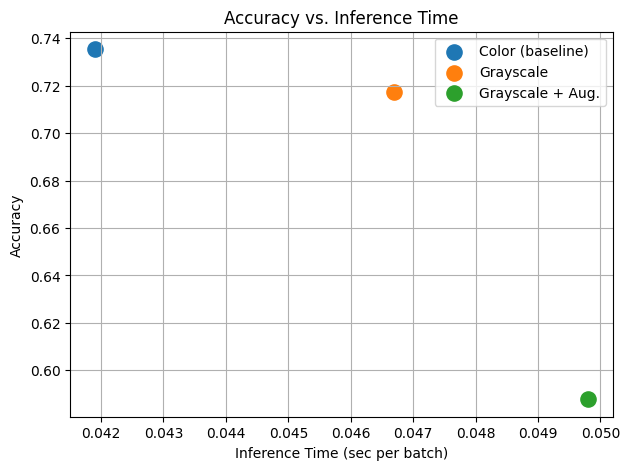

In [7]:
display(Markdown("## Research Questions"))

# 1. Does grayscale hurt? (quantify the loss)
acc_color = summary.loc[summary['experiment']=='color_baseline', 'val_acc_mean'].values[0]
acc_gray = summary.loc[summary['experiment']=='grayscale_baseline', 'val_acc_mean'].values[0]
display(Markdown(f"**1. Does grayscale hurt?**"))
display(Markdown(f"Color baseline accuracy: **{acc_color:.4f}**"))
display(Markdown(f"Grayscale baseline accuracy: **{acc_gray:.4f}**"))
display(Markdown(f"**Accuracy drop from using grayscale:** {acc_color - acc_gray:.4f}"))

# 2. Does augmentation help? (compare)
acc_gray_aug = summary.loc[summary['experiment']=='grayscale_aug', 'val_acc_mean'].values[0]
display(Markdown(f"**2. Does augmentation help?**"))
display(Markdown(f"Grayscale + augmentation accuracy: **{acc_gray_aug:.4f}**"))
display(Markdown(f"**Accuracy gain from augmentation:** {acc_gray_aug - acc_gray:.4f}"))

# 3. Is inference faster/smaller? (show numbers)
display(Markdown("**3. Is inference faster or more memory-efficient for grayscale?**"))
for exp in ['color_baseline', 'grayscale_baseline', 'grayscale_aug']:
    inf_time = summary.loc[summary['experiment']==exp, 'inf_time_cpu_sec_mean'].values[0]
    mem = summary.loc[summary['experiment']==exp, 'inf_mem_cpu_MB_mean'].values[0]
    display(Markdown(f"{label_map[exp]} - Inference time (sec): **{inf_time:.4f}**, Inference memory (MB): **{mem:.1f}**"))

# 4. Are there trade-offs? (accuracy vs. efficiency)
display(Markdown("**4. Are there trade-offs between accuracy and efficiency?**"))
plt.figure(figsize=(7, 5))
for exp in ['color_baseline', 'grayscale_baseline', 'grayscale_aug']:
    acc = summary.loc[summary['experiment']==exp, 'val_acc_mean'].values[0]
    time = summary.loc[summary['experiment']==exp, 'inf_time_cpu_sec_mean'].values[0]
    plt.scatter(time, acc, label=label_map[exp], s=120)
plt.xlabel("Inference Time (sec per batch)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Inference Time")
plt.legend()
plt.grid()
plt.show()

In [8]:
# save summary
summary.to_csv("experiment_summary.csv", index=False)

## Bar plots for Key Experiments

In [9]:
plotdf = summary.sort_values('experiment_label')

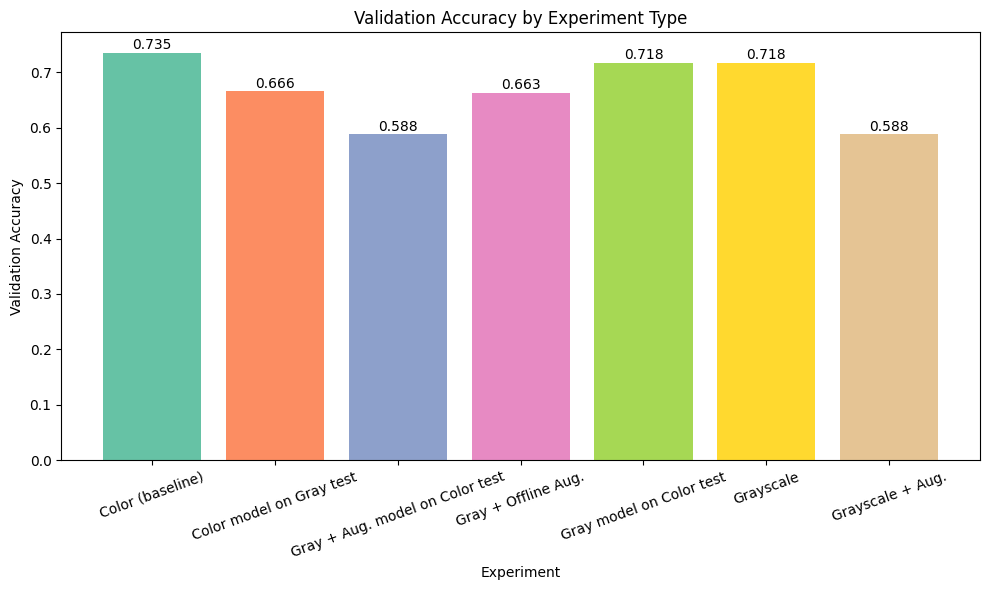

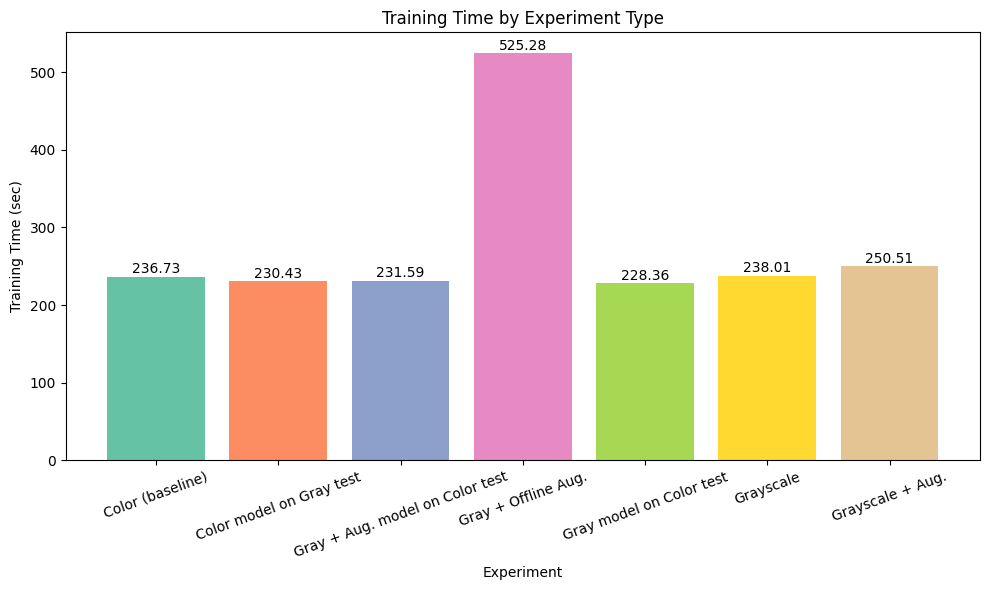

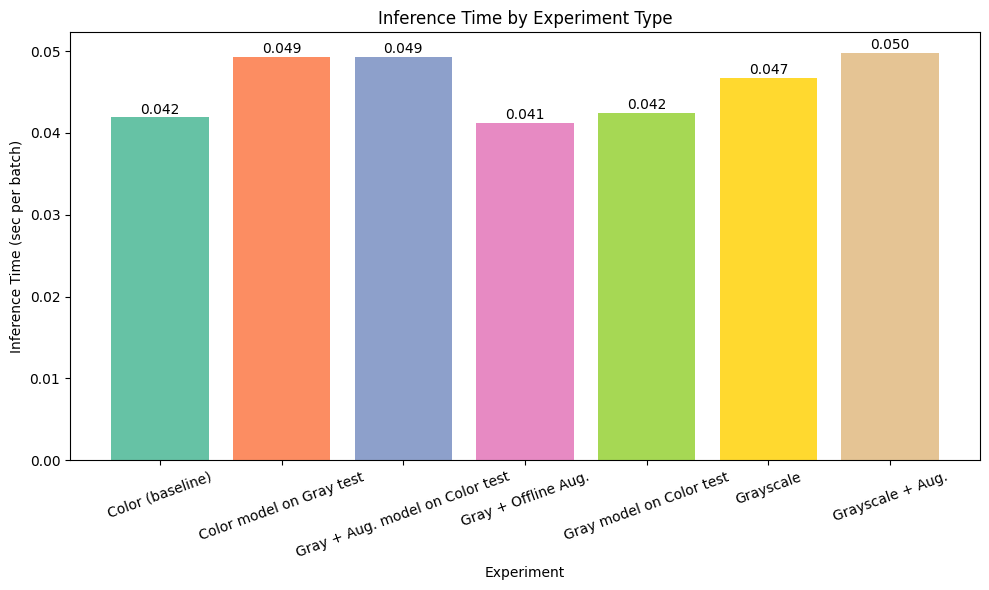

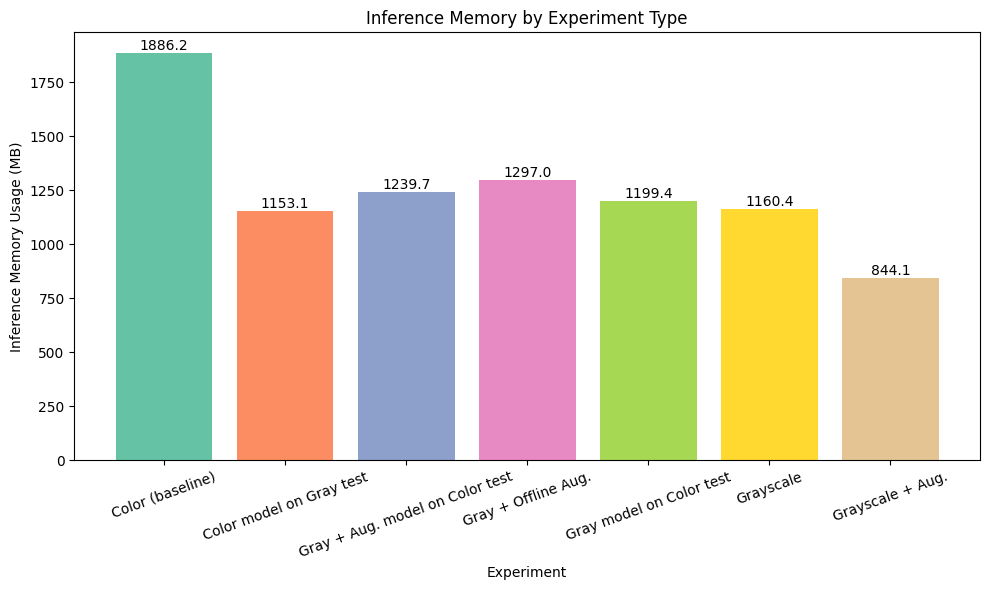

In [14]:
# Bar Plot for Validation Accuracy
plt.figure(figsize=(10,6))
plt.bar(plotdf['experiment_label'], plotdf['val_acc_mean'], color=plt.cm.Set2.colors)
for i, v in enumerate(plotdf['val_acc_mean']):
    plt.text(i, v + 0.001, f"{v:.3f}", ha='center', va='bottom')

plt.xticks(rotation=20)
plt.ylabel("Validation Accuracy")
plt.xlabel("Experiment")
plt.title("Validation Accuracy by Experiment Type")
plt.tight_layout()
plt.show()

# Bar Plot for Training Time
plt.figure(figsize=(10,6))
plt.bar(plotdf['experiment_label'], plotdf['train_time_sec_mean'], color=plt.cm.Set2.colors)
for i, v in enumerate(plotdf['train_time_sec_mean']):
    plt.text(i, v + 0.1, f"{v:.2f}", ha='center', va='bottom')
plt.xticks(rotation=20)
plt.ylabel("Training Time (sec)")
plt.xlabel("Experiment")
plt.title("Training Time by Experiment Type")
plt.tight_layout()
plt.show()

# Bar Plot for Inference Time
plt.figure(figsize=(10,6))
plt.bar(plotdf['experiment_label'], plotdf['inf_time_cpu_sec_mean'], color=plt.cm.Set2.colors)
for i, v in enumerate(plotdf['inf_time_cpu_sec_mean']):
    plt.text(i, v + 0.0001, f"{v:.3f}", ha='center', va='bottom')
plt.xticks(rotation=20)
plt.ylabel("Inference Time (sec per batch)")
plt.xlabel("Experiment")
plt.title("Inference Time by Experiment Type")
plt.tight_layout()
plt.show()


# Bar Plot for Inference Memory Usage
plt.figure(figsize=(10,6))
plt.bar(plotdf['experiment_label'], plotdf['inf_mem_cpu_MB_mean'], color=plt.cm.Set2.colors)
for i, v in enumerate(plotdf['inf_mem_cpu_MB_mean']):
    plt.text(i, v + 0.5, f"{v:.1f}", ha='center', va='bottom')
plt.xticks(rotation=20)
plt.ylabel("Inference Memory Usage (MB)")
plt.xlabel("Experiment")
plt.title("Inference Memory by Experiment Type")
plt.tight_layout()
plt.show()
